# Importing Libraries

In [1]:
import sys
sys.path.append("../")
from Utils.nlp import clean_caption, pad_sequence
from Utils.models import LSTMmodel
from Utils.neural_net import TrainLoop

In [2]:
import torch
from tqdm.notebook import tqdm
import torchtext
import numpy as np
import pandas as pd
from nltk import word_tokenize
from torchtext.data.utils import get_tokenizer

In [3]:
from torch.utils.data import Dataset, DataLoader

In [4]:
torch.manual_seed(1)

# Importing Data

In [5]:
data = pd.read_csv("../Data/Text/Engineered.csv")

In [6]:
y = np.load("../Data/Text/TF-IDF/labels.npy")

# Preprocessing

## Cleaning

In [7]:
data['Caption'] = data['Caption'].apply(clean_caption)
data['Caption'] = data['Caption'].apply(word_tokenize)

## Loading glove embeddings

In [7]:
data['Caption'] = data['Caption'].apply(lambda x: pad_sequence(x, max_seq_length=25))

In [8]:
glove = torchtext.vocab.GloVe(name='twitter.27B', dim=25)

In [9]:
type(glove)

torchtext.vocab.vectors.GloVe

In [10]:
type(glove.get_vecs_by_tokens(data['Caption'][2]))

torch.Tensor

In [11]:
class CustomTextDataset(Dataset):
    def __init__(self, tokens, labels, glove_embeddings:torchtext.vocab.vectors.GloVe):
        self.tokens = tokens
        self.labels = labels
        self.embeddings = glove_embeddings

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        caption_tokens = self.embeddings.get_vecs_by_tokens(self.tokens[index])
        label = self.labels[index]

        return {
            'text_indices': caption_tokens,
            'label': label
        }

In [12]:
glove_path = ".vector_cache/glove.twitter.27B.25d.txt"
embeddings_index = {}
with open(glove_path, 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

word_to_index = {word: i for i, word in enumerate(embeddings_index.keys())}

In [13]:
class CustomTextClassificationDataset(Dataset):
    def __init__(self, tokens, labels, word_to_index:dict):
        self.tokens = tokens
        self.labels = labels
        self.word_to_index = word_to_index

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        text_indices = torch.LongTensor([self.word_to_index.get(word, 0) for word in self.tokens[index]])
        label = self.labels[index]

        return {
            'text_indices': text_indices,
            'label': label
        }

## Splitting data into train test and validation set

In [14]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(np.array(data['Caption']), y, test_size=0.2, shuffle=True, stratify=y, random_state=1)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.125, shuffle=True, stratify=train_y, random_state=1)

In [15]:
train_set = CustomTextClassificationDataset(train_x, train_y, word_to_index)
val_set = CustomTextClassificationDataset(val_x, val_y, word_to_index)

In [16]:
len(word_to_index)

1193514

In [17]:
a = train_set[1]
a

{'text_indices': tensor([   3,  304,    0,    2,   53,  724,   80,  129,   16, 4352,   13, 2530,
           39,   11, 1362,   26,  623, 6963, 1240,    9,  111,  258,    9,  506,
            0]),
 'label': 2}

In [18]:
train_loader = DataLoader(train_set, 32)
val_loader = DataLoader(val_set, 32)

# Modelling

## Model Architecture

In [19]:
class LSTMmodel(torch.nn.Module):
    def __init__(self, n_layers, embed_dim, hidden_dim, embedding:str="twitter.27B", bidirectionality:bool=False) -> None:
        super().__init__()
        glove_embeddings = torchtext.vocab.GloVe(embedding, embed_dim)
        self.embedding = torch.nn.Embedding.from_pretrained(glove_embeddings.vectors, freeze=False)
        self.lstm = torch.nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True, bidirectional=bidirectionality)
        if bidirectionality == False:
            self.linear = torch.nn.Linear(hidden_dim, 3)
        else:
            self.linear = torch.nn.Linear(2*hidden_dim, 3)

    def forward(self, x):
        a = self.embedding(x)
        a, _ = self.lstm(a)
        a =  a[:,-1,:]
        a = self.linear(a)
        return torch.nn.functional.log_softmax(a, dim=1)

## Initialization

In [24]:
modelv1 = LSTMmodel(4, 25, 256, bidirectionality=True)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.NAdam(modelv1.parameters(), 0.002)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.5, 8)

In [26]:
sum(p.numel() for p in modelv1.parameters())

35149853

## Train Loop

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau

def TrainLoop(
    model,
    optimizer:torch.optim.Optimizer,
    criterion:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    val_dataloader:torch.utils.data.DataLoader,
    scheduler:torch.optim.lr_scheduler.ReduceLROnPlateau,
    num_epochs:int=20,
    early_stopping_rounds:int=5,
    return_best_model:bool=True,
    device:str='cpu'
):
    model.to(device)
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    total_train_loss = []
    total_val_loss = []
    best_model_weights = model.state_dict()

    train_accuracies = []
    val_accuracies = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        print("\nEpoch {}\n----------".format(epoch))
        train_loss = 0
        for i, batch in enumerate(train_dataloader):
            caption_tokens = batch['text_indices'].to(device)
            # caption_tokens = caption_tokens.to(torch.float32)
            labels = batch['label'].to(device, dtype=torch.long)
            optimizer.zero_grad()
            outputs = model(caption_tokens)
            loss = criterion(outputs, labels)
            train_loss += loss
            loss.backward()
            optimizer.step()
            print("Loss for batch {} = {}".format(i, loss))

        print("\nTraining Loss for epoch {} = {}\n".format(epoch, train_loss))
        total_train_loss.append(train_loss/len(train_dataloader.dataset))

        model.eval()
        validation_loss = 0
        with torch.inference_mode():
            val_true_labels = []
            train_true_labels = []
            val_pred_labels = []
            train_pred_labels = []
            for batch in val_dataloader:
                caption_tokens = batch['text_indices'].to(device)
                # caption_tokens = caption_tokens.to(torch.float32)
                labels = batch['label'].to(device, dtype=torch.long)
                outputs = model(caption_tokens)
                loss = criterion(outputs, labels)
                validation_loss += loss

                outputs = torch.argmax(outputs, dim=1)
                val_true_labels.extend(labels.cpu().numpy())
                val_pred_labels.extend(outputs.cpu().numpy())

            for batch in train_dataloader:
                caption_tokens = batch['text_indices'].to(device)
                # caption_tokens = caption_tokens.to(torch.float32)
                labels = batch['label'].to(device, dtype=torch.long)
                outputs = model(caption_tokens)

                outputs = torch.argmax(outputs, dim=1)
                train_true_labels.extend(labels.cpu().numpy())
                train_pred_labels.extend(outputs.cpu().numpy())

            if validation_loss < best_val_loss:
                best_val_loss = validation_loss
                epochs_without_improvement = 0
                best_model_weights = model.state_dict()
            else:
                epochs_without_improvement += 1

            val_true_labels = np.array(val_true_labels)
            train_true_labels = np.array(train_true_labels)
            val_pred_labels = np.array(val_pred_labels)
            train_pred_labels = np.array(train_pred_labels)

            train_accuracy = accuracy_score(train_true_labels, train_pred_labels)
            val_accuracy = accuracy_score(val_true_labels, val_pred_labels)

            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            print(f"Current Validation Loss = {validation_loss}")
            print(f"Best Validation Loss = {best_val_loss}")
            print(f"Epochs without Improvement = {epochs_without_improvement}")

            print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
            print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

        total_val_loss.append(validation_loss/len(val_dataloader.dataset))
        scheduler.step(validation_loss)
        if epochs_without_improvement == early_stopping_rounds:
            break

    if return_best_model == True:
        model.load_state_dict(best_model_weights)
    total_train_loss = [item.cpu().detach().numpy() for item in total_train_loss]
    total_val_loss = [item.cpu().detach().numpy() for item in total_val_loss]

    total_train_loss = np.array(total_train_loss)
    total_val_loss = np.array(total_val_loss)

    train_accuracies = np.array(train_accuracies)
    val_accuracies = np.array(val_accuracies)

    x_train = np.arange(len(total_train_loss))
    x_val = np.arange(len(total_val_loss))
    
    sns.set_style('whitegrid')
    plt.figure(figsize=(14,5))
    
    plt.subplot(1,2,1)
    sns.lineplot(x=x_train, y=total_train_loss, label='Training Loss')
    sns.lineplot(x=x_val, y=total_val_loss, label='Validation Loss')
    plt.title("Loss over {} Epochs".format(len(total_train_loss)))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks(np.arange(len(total_train_loss)))
    
    plt.subplot(1,2,2)
    sns.lineplot(x=x_train, y=train_accuracies, label='Training Accuracy')
    sns.lineplot(x=x_val, y=val_accuracies, label='Validation Accuracy')
    plt.title("Accuracy over {} Epochs".format(len(total_train_loss)))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.xticks(np.arange(len(total_train_loss)))

    plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 0
----------
Loss for batch 0 = 1.0954129695892334
Loss for batch 1 = 1.117844820022583
Loss for batch 2 = 1.0888476371765137
Loss for batch 3 = 1.134114146232605
Loss for batch 4 = 1.1121652126312256
Loss for batch 5 = 1.0995631217956543
Loss for batch 6 = 1.1006276607513428
Loss for batch 7 = 1.0872316360473633
Loss for batch 8 = 1.1005913019180298
Loss for batch 9 = 1.0858919620513916
Loss for batch 10 = 1.0892263650894165
Loss for batch 11 = 1.0724705457687378
Loss for batch 12 = 1.3935279846191406
Loss for batch 13 = 1.0823384523391724
Loss for batch 14 = 1.1162610054016113
Loss for batch 15 = 1.0946420431137085
Loss for batch 16 = 1.1036063432693481
Loss for batch 17 = 1.0854909420013428
Loss for batch 18 = 1.118122935295105
Loss for batch 19 = 1.0858770608901978
Loss for batch 20 = 1.1070743799209595
Loss for batch 21 = 1.0969454050064087
Loss for batch 22 = 1.097622036933899
Loss for batch 23 = 1.0685104131698608
Loss for batch 24 = 0.9649468064308167
Loss for batch 25 =

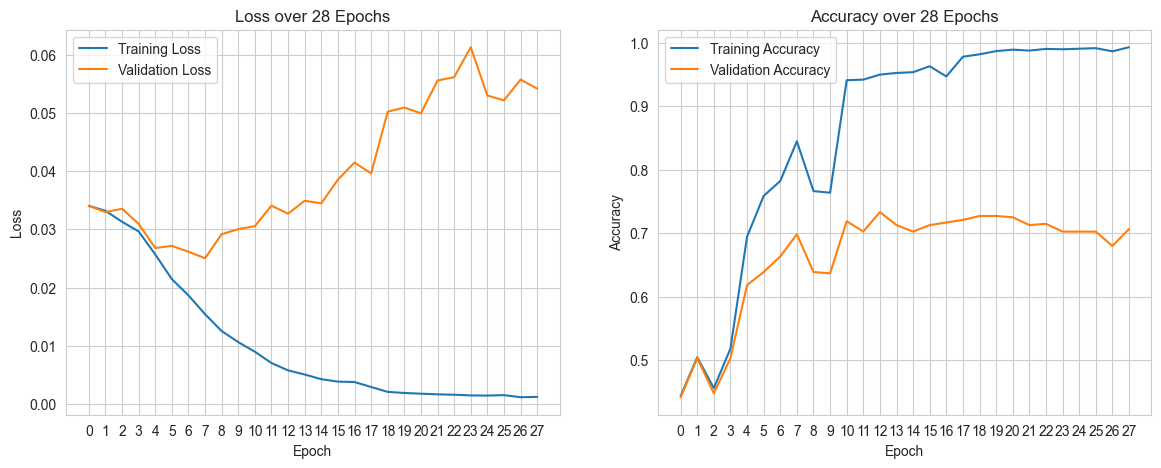

In [27]:
TrainLoop(modelv1, optimizer, loss_fn, train_loader, val_loader, scheduler, 100, 20, device='cuda')

In [28]:
test_set = CustomTextClassificationDataset(test_x, test_y, word_to_index)
test_loader = DataLoader(test_set, 32)
true_labels = []
pred_labels = []
with torch.inference_mode():
    for batch in test_loader:
        caption_tokens = batch['text_indices'].to('cuda')
        labels = batch['label'].to('cuda', dtype=torch.long)
        preds = torch.argmax(modelv1(caption_tokens), dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

modelv1_accuracy = accuracy_score(true_labels, pred_labels)

print(f'Accuracy: {modelv1_accuracy * 100:.2f}%')

Accuracy: 70.74%


In [29]:
torch.save(modelv1.state_dict(), 'lstm11.pth')

In [30]:
modelv2 = LSTMmodel(3, 25, 256, bidirectionality=True)
loss_fn_2 = torch.nn.NLLLoss()
optimizer_2 = torch.optim.NAdam(modelv2.parameters(), 0.002)
scheduler_2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_2, 'min', 0.3, 8)

In [31]:
sum(p.numel() for p in modelv2.parameters())

33572893

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 0
----------
Loss for batch 0 = 1.0917292833328247
Loss for batch 1 = 1.134045958518982
Loss for batch 2 = 1.0867518186569214
Loss for batch 3 = 1.1193300485610962
Loss for batch 4 = 1.1089468002319336
Loss for batch 5 = 1.1012405157089233
Loss for batch 6 = 1.1010876893997192
Loss for batch 7 = 1.0839693546295166
Loss for batch 8 = 1.104689598083496
Loss for batch 9 = 1.084059476852417
Loss for batch 10 = 1.0884870290756226
Loss for batch 11 = 1.0791072845458984
Loss for batch 12 = 1.0685181617736816
Loss for batch 13 = 1.5048125982284546
Loss for batch 14 = 1.1129525899887085
Loss for batch 15 = 1.0836416482925415
Loss for batch 16 = 1.1113070249557495
Loss for batch 17 = 1.071638584136963
Loss for batch 18 = 1.124261498451233
Loss for batch 19 = 1.0869672298431396
Loss for batch 20 = 1.110395908355713
Loss for batch 21 = 1.1025261878967285
Loss for batch 22 = 1.0979725122451782
Loss for batch 23 = 1.0856883525848389
Loss for batch 24 = 1.0725948810577393
Loss for batch 25 = 1

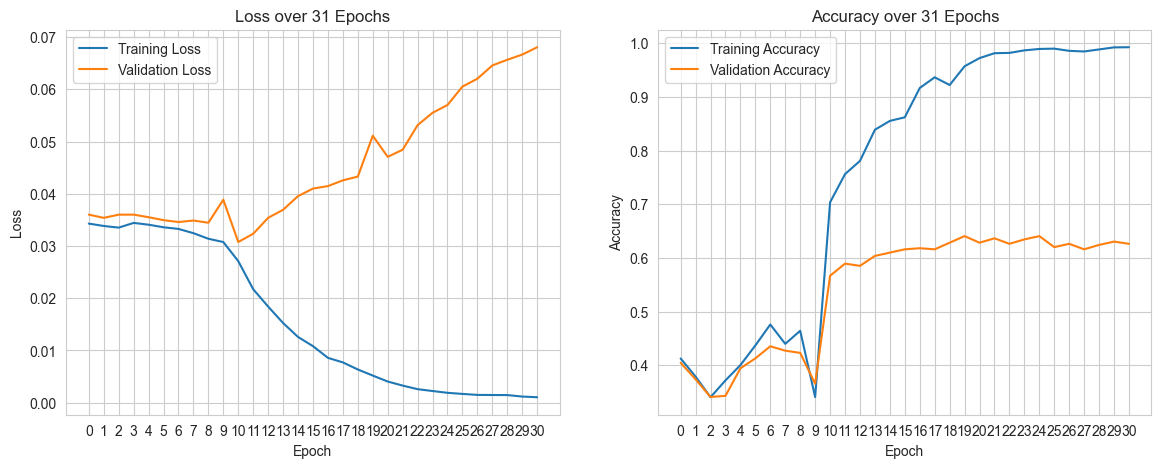

In [32]:
TrainLoop(modelv2, optimizer_2, loss_fn_2, train_loader, val_loader, scheduler_2, 100, 20, device='cuda')

In [33]:
# test_set = CustomTextClassificationDataset(test_x, test_y, word_to_index)
# test_loader = DataLoader(test_set, 32)
true_labels = []
pred_labels = []
with torch.inference_mode():
    for batch in test_loader:
        caption_tokens = batch['text_indices'].to('cuda')
        labels = batch['label'].to('cuda', dtype=torch.long)
        preds = torch.argmax(modelv2(caption_tokens), dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

modelv2_accuracy = accuracy_score(true_labels, pred_labels)

print(f'Accuracy: {modelv2_accuracy * 100:.2f}%')

Accuracy: 60.78%


In [37]:
modelv3 = LSTMmodel(3, 25, 512, bidirectionality=True)
loss_fn_3 = torch.nn.NLLLoss()
optimizer_3 = torch.optim.NAdam(modelv3.parameters(), 0.001)
scheduler_3 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_3, 'min', 0.4, 8)

In [38]:
sum(p.numel() for p in modelv3.parameters())

44647965

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 0
----------
Loss for batch 0 = 1.0991579294204712
Loss for batch 1 = 1.1129205226898193
Loss for batch 2 = 1.0859681367874146
Loss for batch 3 = 1.1241397857666016
Loss for batch 4 = 1.1067978143692017
Loss for batch 5 = 1.1018072366714478
Loss for batch 6 = 1.0994982719421387
Loss for batch 7 = 1.086398959159851
Loss for batch 8 = 1.1084955930709839
Loss for batch 9 = 1.084686517715454
Loss for batch 10 = 1.0875650644302368
Loss for batch 11 = 1.0784155130386353
Loss for batch 12 = 1.4079875946044922
Loss for batch 13 = 1.0911625623703003
Loss for batch 14 = 1.120188593864441
Loss for batch 15 = 1.0992918014526367
Loss for batch 16 = 1.1003555059432983
Loss for batch 17 = 1.085225224494934
Loss for batch 18 = 1.1184362173080444
Loss for batch 19 = 1.0849422216415405
Loss for batch 20 = 1.103843092918396
Loss for batch 21 = 1.1087143421173096
Loss for batch 22 = 1.0956099033355713
Loss for batch 23 = 1.083115816116333
Loss for batch 24 = 1.0610933303833008
Loss for batch 25 = 1

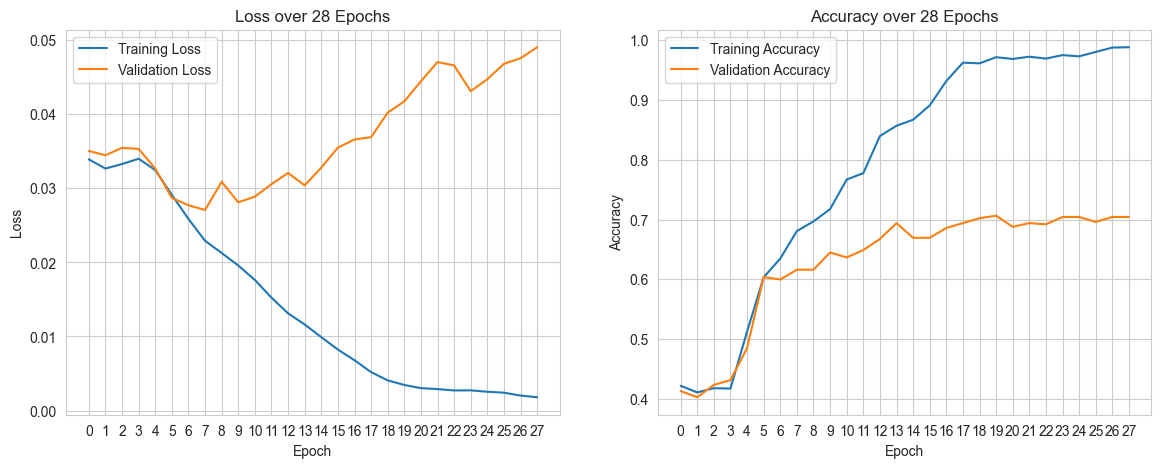

In [39]:
TrainLoop(modelv3, optimizer_3, loss_fn_3, train_loader, val_loader, scheduler_3, 100, 20, device='cuda')

In [40]:
# test_set = CustomTextClassificationDataset(test_x, test_y, word_to_index)
# test_loader = DataLoader(test_set, 32)
true_labels = []
pred_labels = []
with torch.inference_mode():
    for batch in test_loader:
        caption_tokens = batch['text_indices'].to('cuda')
        labels = batch['label'].to('cuda', dtype=torch.long)
        preds = torch.argmax(modelv3(caption_tokens), dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

modelv3_accuracy = accuracy_score(true_labels, pred_labels)

print(f'Accuracy: {modelv3_accuracy * 100:.2f}%')

Accuracy: 68.28%


# Modelling 2

In [42]:
class LSTMmodelv2(torch.nn.Module):
    def __init__(self, n_layers, embed_dim, hidden_dim, embedding:str="twitter.27B", bidirectionality:bool=False) -> None:
        super().__init__()
        glove_embeddings = torchtext.vocab.GloVe(embedding, embed_dim)
        self.embedding = torch.nn.Embedding.from_pretrained(glove_embeddings.vectors, freeze=True)
        self.lstm = torch.nn.LSTM(embed_dim, hidden_dim, n_layers, batch_first=True, bidirectional=bidirectionality)
        if bidirectionality == False:
            self.linear = torch.nn.Linear(hidden_dim, 3)
        else:
            self.linear = torch.nn.Linear(2*hidden_dim, 3)

    def forward(self, x):
        a = self.embedding(x)
        a, _ = self.lstm(a)
        a =  a[:,-1,:]
        a = self.linear(a)
        return torch.nn.functional.log_softmax(a, dim=1)

In [43]:
modelv4 = LSTMmodelv2(4, 25, 256, bidirectionality=True)
loss_fn_4 = torch.nn.NLLLoss()
optimizer_4 = torch.optim.NAdam(modelv4.parameters(), 0.001)
scheduler_4 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_4, 'min', 0.4, 8)

  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 0
----------
Loss for batch 0 = 1.0993565320968628
Loss for batch 1 = 1.1046375036239624
Loss for batch 2 = 1.089618444442749
Loss for batch 3 = 1.1192024946212769
Loss for batch 4 = 1.107176423072815
Loss for batch 5 = 1.095347285270691
Loss for batch 6 = 1.101747989654541
Loss for batch 7 = 1.090149998664856
Loss for batch 8 = 1.1008758544921875
Loss for batch 9 = 1.0866656303405762
Loss for batch 10 = 1.0908020734786987
Loss for batch 11 = 1.0980010032653809
Loss for batch 12 = 1.0312471389770508
Loss for batch 13 = 1.4944510459899902
Loss for batch 14 = 1.1400336027145386
Loss for batch 15 = 1.080434799194336
Loss for batch 16 = 1.111159324645996
Loss for batch 17 = 1.068657636642456
Loss for batch 18 = 1.1230788230895996
Loss for batch 19 = 1.0808005332946777
Loss for batch 20 = 1.111127257347107
Loss for batch 21 = 1.1041368246078491
Loss for batch 22 = 1.0953290462493896
Loss for batch 23 = 1.0785484313964844
Loss for batch 24 = 1.0526187419891357
Loss for batch 25 = 1.09

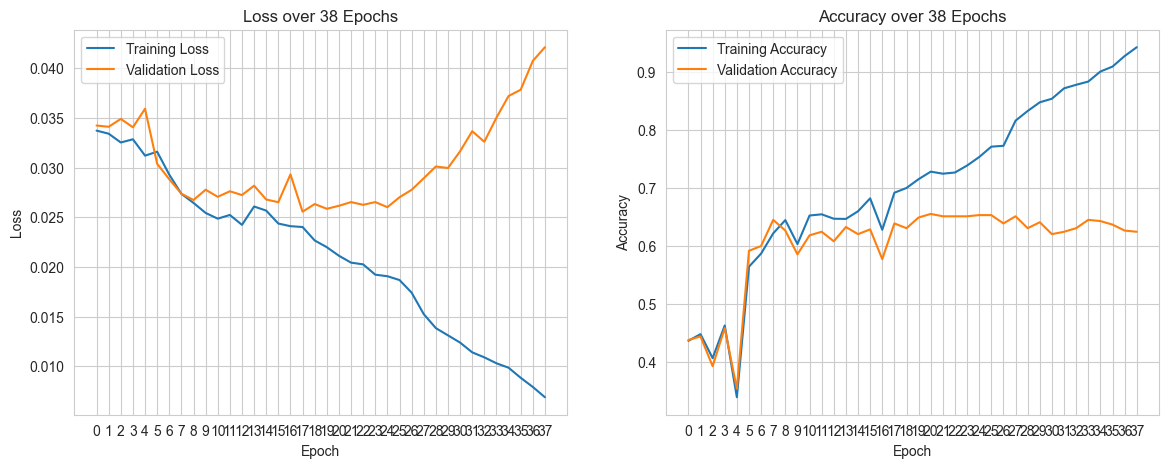

In [44]:
TrainLoop(modelv4, optimizer_4, loss_fn_4, train_loader, val_loader, scheduler_4, 100, 20, device='cuda')

In [45]:
# test_set = CustomTextClassificationDataset(test_x, test_y, word_to_index)
# test_loader = DataLoader(test_set, 32)
true_labels = []
pred_labels = []
with torch.inference_mode():
    for batch in test_loader:
        caption_tokens = batch['text_indices'].to('cuda')
        labels = batch['label'].to('cuda', dtype=torch.long)
        preds = torch.argmax(modelv4(caption_tokens), dim=1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

modelv4_accuracy = accuracy_score(true_labels, pred_labels)

print(f'Accuracy: {modelv4_accuracy * 100:.2f}%')

Accuracy: 66.43%


In [51]:
modelv5 = LSTMmodelv2(4, 25, 512, bidirectionality=True)
loss_fn_5 = torch.nn.NLLLoss()
optimizer_5 = torch.optim.NAdam(modelv5.parameters(), 0.001)
scheduler_5 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_5, 'min', 0.4, 8)

In [48]:
def initialize_weights(layer):
    if isinstance(layer, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight)  # Xavier (Glorot) initialization
        torch.nn.init.constant_(layer.bias, 0)  # Initialize biases to zero
    elif isinstance(layer, torch.nn.LSTM):
        # Initialize LSTM weights and biases
        for name, param in layer.named_parameters():
            if 'weight' in name:
                torch.nn.init.orthogonal_(param)  # Orthogonal initialization for LSTM weights
            elif 'bias' in name:
                torch.nn.init.constant_(param, 0)

In [52]:
modelv5.apply(initialize_weights)

LSTMmodelv2(
  (embedding): Embedding(1193514, 25)
  (lstm): LSTM(25, 512, num_layers=4, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=1024, out_features=3, bias=True)
)

In [55]:
TrainLoop(modelv5, optimizer_5, loss_fn_5, train_loader, val_loader, scheduler_5, 100, 20, device='cuda')

OutOfMemoryError: CUDA out of memory. Tried to allocate 82.00 MiB. GPU 0 has a total capacty of 4.00 GiB of which 0 bytes is free. Of the allocated memory 3.26 GiB is allocated by PyTorch, and 129.90 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [54]:
torch.cuda.empty_cache()

# Modelling 3

glove_path = ".vector_cache/glove.twitter.27B.50d.txt"
embeddings_index = {}
with open(glove_path, 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

word_to_index = {word: i for i, word in enumerate(embeddings_index.keys())}

data = pd.read_csv("../Data/Text/Engineered.csv")
data['Caption'] = data['Caption'].apply(clean_caption)
data['Caption'] = data['Caption'].apply(word_tokenize)
data['Caption'] = data['Caption'].apply(lambda x: pad_sequence(x, max_seq_length=30))

from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(np.array(data['Caption']), y, test_size=0.2, shuffle=True, stratify=y, random_state=1)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.125, shuffle=True, stratify=train_y, random_state=1)
train_set = CustomTextClassificationDataset(train_x, train_y, word_to_index)
val_set = CustomTextClassificationDataset(val_x, val_y, word_to_index)
train_loader = DataLoader(train_set, 32)
val_loader = DataLoader(val_set, 32)